# Mapping jobs location

In [18]:
from indeed import IndeedClient
from mpl_toolkits.basemap import Basemap
import sqlite3
from time import sleep # To prevent overwhelming the server between connections
import pandas as pd # For converting results to a dataframe and bar chart plots
from matplotlib.patches import Polygon
from matplotlib.colors import rgb2hex
import matplotlib as mpl
import numpy as np
import operator
import matplotlib.pyplot as plt
from prettytable import PrettyTable

cmap= plt.cm.Blues
%matplotlib inline
client = IndeedClient(publisher ="9124561496937265")


short_state_names = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


1043


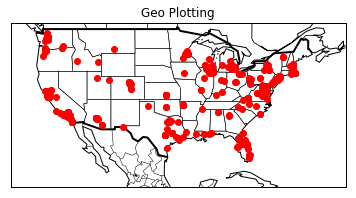

In [2]:
conn = sqlite3.connect('indeed.db')
c = conn.cursor()
#select in jobs all unique values in column = employer
sql_manager = "SELECT * FROM jobs;"
c.execute(sql_manager)
result = c.fetchall()
print(len(result))
data_pts = []        
for entry in result:
    data_pts.append([entry[6], entry[7]])

def mapTut(pts):

    m = Basemap(projection='mill',llcrnrlat=20,urcrnrlat=50,\
                llcrnrlon=-130,urcrnrlon=-60,resolution='c')
    m.bluemarble()
    m.drawcoastlines()
    m.drawcountries(linewidth=2)
    m.drawstates()
    #m.fillcontinents(color='#04BAE3',lake_color='#FFFFFF')
    m.drawmapboundary(fill_color='#FFFFFF')

    for point in pts:
        if len(point[0] ) > 0:
            lat, lon = float(point[1]), float(point[0])
            x,y = m(lon,lat)
            m.plot(x,y, 'ro')
   
    # Houston, Texas


    
    plt.title("Geo Plotting")
    plt.show()


mapTut(data_pts)

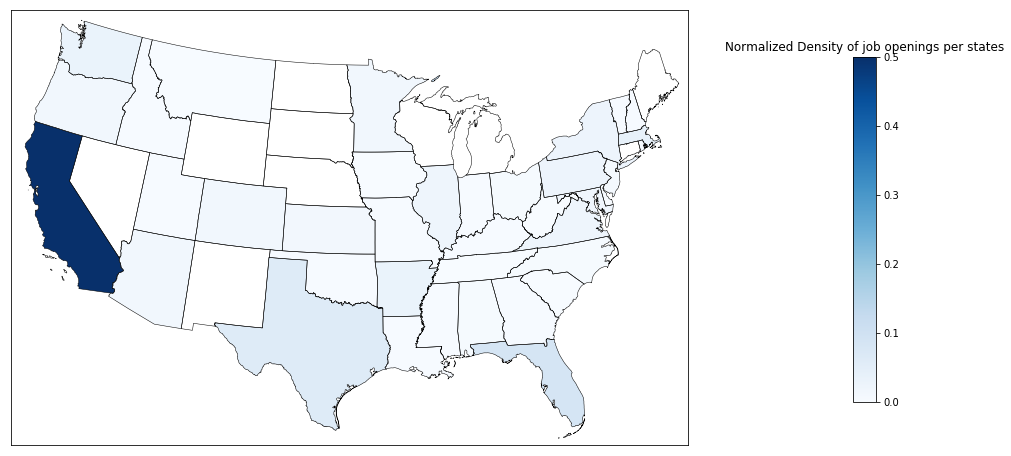

In [3]:
################################
# Get data - select data from db
###############################
sql_all_jobs = "SELECT jobkey, state FROM jobs;"
c.execute(sql_all_jobs)
all_jobs = c.fetchall()
total_nb_jobs = len(all_jobs)
#create a dict with count of jobs per state
jobs_in_state = {}

for job_entry in all_jobs:
    this_state = job_entry[1]
    #this_jobkey = job_entry[0]
    if len(this_state) > 0:
        long_name = short_state_names[this_state]
        if long_name in jobs_in_state:
            jobs_in_state[long_name] += 1
        else:
            jobs_in_state[long_name] = 1
        
# Need max and min value to normalize the colorbar
state_max =  max(jobs_in_state, key=jobs_in_state.get)
state_min =  min(jobs_in_state, key=jobs_in_state.get)
max_jobs = jobs_in_state[state_max]
min_jobs = jobs_in_state[state_min]
job_density_max = 1-(total_nb_jobs - max_jobs)*1.0/(total_nb_jobs)

# create the map
fig, ax = plt.subplots(figsize=(16,8))
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])



for this_state in jobs_in_state:
    #Calculate statistics
    nb_jobs = jobs_in_state[this_state]
    ax = plt.gca() # get current axes instance
    # get state_name and draw the filled polygon
    seg = map.states[state_names.index(this_state)]
    job_density = 1-(total_nb_jobs - nb_jobs)*1.0/(total_nb_jobs)
    normalized_alpha = job_density / (job_density_max)
    #poly = Polygon(seg, facecolor='#1B4F72', alpha=normalized_alpha)
    poly = Polygon(seg, facecolor=cmap(normalized_alpha)) 
    ax.add_patch(poly)

# Make an axis for the colorbar on the right side

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)
cmap = plt.cm.Blues
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')


plt.title('Normalized Density of job openings per states')
plt.show()

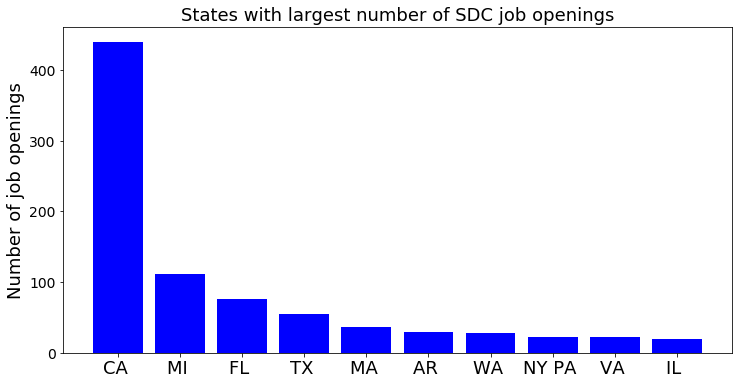

In [4]:
#### Plot number of jobs per state
####################################
show_n_largest = 10 #

def get_xaxis_labels(y_pt, all_data, ls_states):
    """
    Attach a text label above each bar displaying its height
    """
    txt_labels = ''
    for state in all_data:
        if all_data[state] == y_pt:
            state_abrev = list(ls_states.keys())[list(ls_states.values()).index(state)]
            txt_labels = state_abrev+' '+txt_labels
    return txt_labels


job_cnts = []
for item in jobs_in_state:
    job_cnts.append(jobs_in_state[item])
#sort the unique counts
sorted_job_cnts = sorted(set(job_cnts), reverse=True)
#exception: 
if show_n_largest > len(sorted_job_cnts):
    show_n_largest = len(sorted_job_cnts)
x = np.arange(0, show_n_largest, 1)
fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x, sorted_job_cnts[0:show_n_largest], color='b')
# add some text for labels, title and axes ticks
ax.set_ylabel('Number of job openings', fontsize=18)
ax.set_title('States with largest number of SDC job openings', fontsize=18)
xticklabels = []
for y_pt in sorted_job_cnts[0:show_n_largest]:
    x_label = get_xaxis_labels(y_pt, jobs_in_state, short_state_names)
    xticklabels.append(x_label)  
#ax.set_xticklabels(xticklabels, rotation='vertical')
plt.xticks(x, xticklabels, fontsize=18)
ax.tick_params(axis='y', labelsize=14)
#tick.label.set_fontsize(14) 
#autolabel(rects1)


plt.show()

 # List of automotive assembly plants in the United States
 
 
 https://en.wikipedia.org/wiki/List_of_automotive_assembly_plants_in_the_United_States


{'Kentucky': 4, 'Mississippi': 2, 'Georgia': 1, 'Tennessee': 3, 'Illinois': 2, 'California': 1, 'Ohio': 5, 'South Carolina': 2, 'Indiana': 6, 'Michigan': 9, 'Kansas': 1, 'Alabama': 3, 'Texas': 2, 'Missouri': 2}


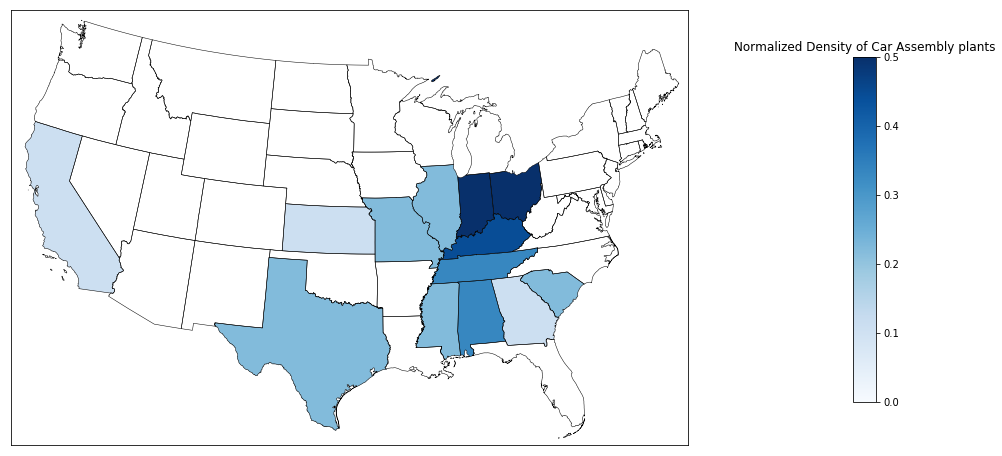

In [5]:
data_us_plants = {'GM': ['Texas', 'Kentucky', 'Michigan', 'Kansas', 'Michigan', 'Indiana', 'Michigan', 'Ohio',
                        'Tennessee', 'Missouri'],
                  'Ford Motor Company': ['Michigan', 'Illinois', 'Michigan', 'Missouri', 'Kentucky', 'Kentucky',
                  'Michigan', 'Ohio'],
                  'Fiat Chrysler': ['Illinois', 'Michigan', 'Michigan', 'Ohio', 'Michigan'],
                  'Tesla': ['California'],
                  'AM General': ['Indiana'],
                  'Toyota Motor Corporation': ['Kentucky', 'Indiana', 'Texas', 'Mississippi'],
                  'Honda': ['Ohio', 'Ohio', 'Alabama', 'Indiana', 'Indiana'],
                  'Nissan': ['Tennessee', 'Mississippi'],
                  'Fuji Heavy Industries': ['Indiana'],
                  'Volkswagen': ['Tennessee'],
                  'Hyundai Motor': ['Alabama'],
                  'Kia Motors': ['Georgia'],
                  'BMW Group': ['South Carolina'],
                  'Daimler': ['Alabama', 'South Carolina']
                  }


##########
# Build dictionary of plant state density per state
###############################
plants_location = {}
total_nb_plants = 0
for brand in data_us_plants:
    for this_state in data_us_plants[brand]:
        total_nb_plants += 1
        if this_state in plants_location:
            plants_location[this_state] += 1
        else:
            plants_location[this_state] = 1

print(plants_location)          
# Need max and min value to normalize the colorbar
state_max =  max(plants_location, key=plants_location.get)
state_min =  min(plants_location, key=plants_location.get)
max_plants = plants_location[state_max]
min_plants = plants_location[state_min]
plant_density_max = 1-(total_nb_plants - max_plants)*1.0/(total_nb_plants)


# create the map
fig, ax = plt.subplots(figsize=(16,8))
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)
for this_state in plants_location:
    #Calculate statistics
    nb_plants = plants_location[this_state]
    ax = plt.gca() # get current axes instance
    # get Texas and draw the filled polygon
    seg = map.states[state_names.index(this_state)]
    plant_density = 1-(total_nb_plants - nb_plants)*1.0/(total_nb_plants)
    normalized_alpha = plant_density / (plant_density_max)
    #poly = Polygon(seg, facecolor='#1B4F72', alpha=normalized_alpha)
    poly = Polygon(seg, facecolor=cmap(norm(normalized_alpha)) )
    ax.add_patch(poly)

# Make an axis for the colorbar on the right side

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)
cmap = plt.cm.Blues
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional')


plt.title('Normalized Density of Car Assembly plants')
plt.show()

# WHO IS HIRING?

In [37]:
conn = sqlite3.connect('indeed.db')
c = conn.cursor()
#select in jobs all unique values in column = employer
sql_manager = "SELECT jobkey, employer FROM jobs;"
c.execute(sql_manager)
result = c.fetchall()

employers = {}

for this_job in result:
    this_jobkey = this_job[0]
    employer = this_job[1]
    #make sure the extracted employer name is not empty
    if len(employer) > 0:
        if employer in employers:
            employers[employer] += 1
        else:
            employers[employer] = 1


print('Total Nbr of companies {}'.format(len(employers)) )
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Total Nbr of companies 330
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+
|                                                                                                                                                                                                    Company                                                                                                                                                                                                     | Nbr of job postings |
+--------------------------------------------------------------------------------------------------------------------------

# WHAT skillsets?

Total Nbr of companies 11
{'opencv': 13, 'keras': 1, 'ruby': 7, 'php': 2, 'c++': 129, 'java': 27, 'matlab': 33, 'c': 87, 'ros': 23, 'tensorflow': 13, 'python': 91}


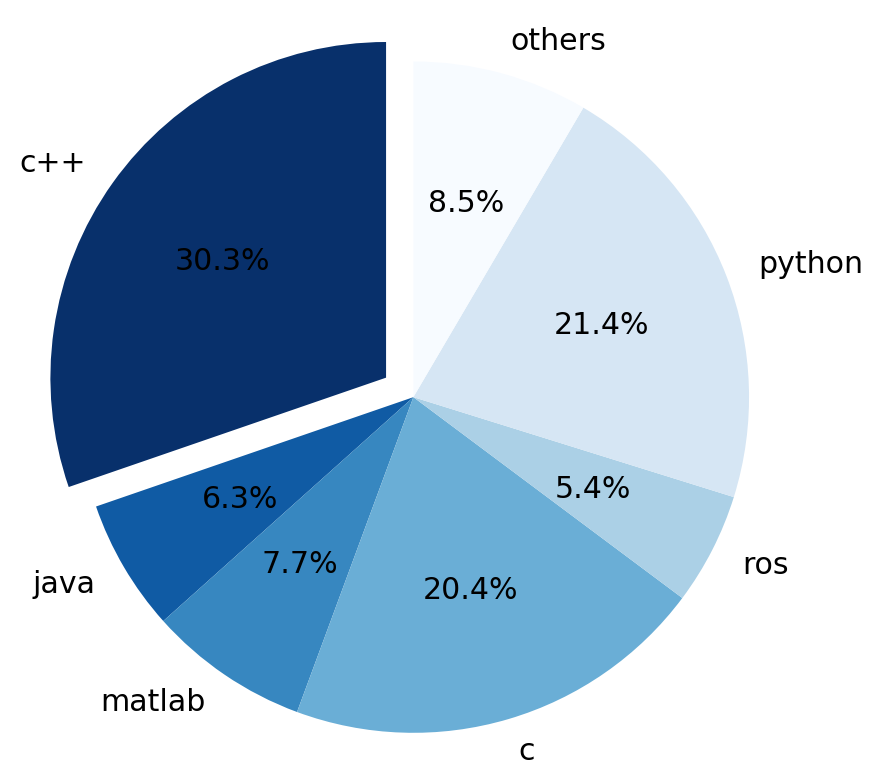

In [64]:
conn = sqlite3.connect('indeed.db')
c = conn.cursor()
#select in jobs all unique values in column = employer
sql_manager = "SELECT jobkey, progskills_req FROM progskills;"
c.execute(sql_manager)
result = c.fetchall()
nb_entry = len(result)
programming = {}

for this_job in result:
    this_jobkey = this_job[0]
    prog = this_job[1]
    #make sure the extracted cell is not empty
    if len(prog) > 0:
        if prog in programming:
            programming[prog] += 1
        else:
            programming[prog] = 1


print('Total Nbr of companies {}'.format(len(programming)) )
print(programming)
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
sum_sz = 0

for this_prog in programming:
    pct = programming[this_prog]*1.0/nb_entry
    if pct > 0.05:
        sizes.append(pct)
        sum_sz = sum_sz + pct
        labels.append(this_prog)
    
others_sz = 1 - sum_sz
sizes.append(others_sz)
labels.append('others')

explode = (0.1, 0, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
mpl.rcParams['font.size'] = 30
fig1, ax1 = plt.subplots(figsize=(14,14))
cmap = plt.cm.Blues
colors = cmap(np.linspace(1, 0, 7))
ax1.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Education requirement

Total Nbr of degrees 3
{'phd': 78, 'master': 160, 'bachelor': 174}


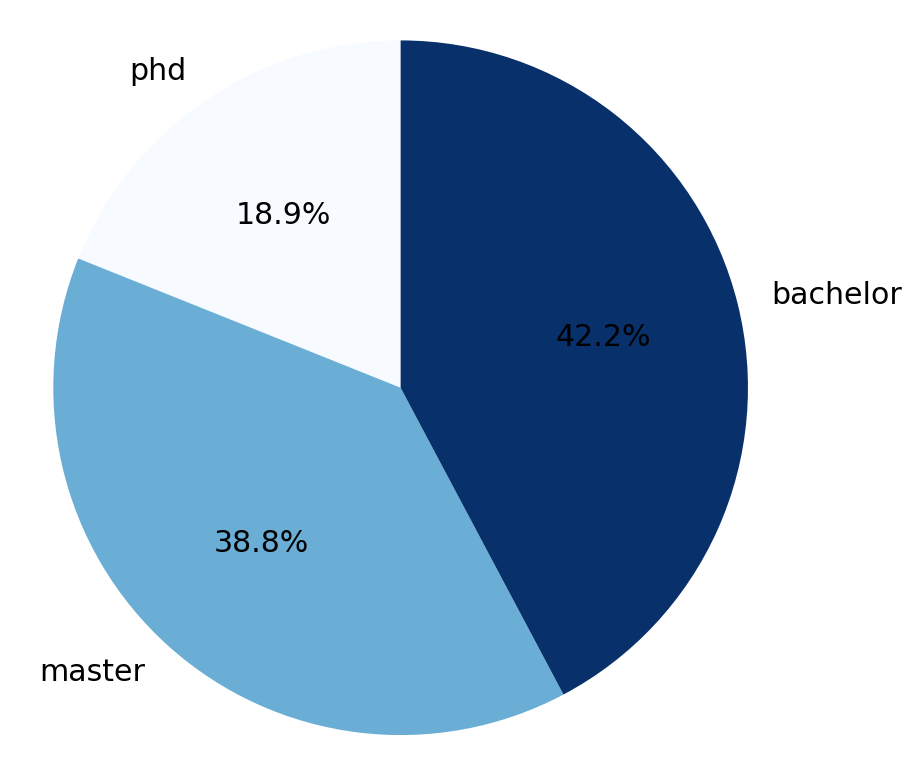

In [79]:
conn = sqlite3.connect('indeed.db')
c = conn.cursor()
#select in jobs all unique values in column = employer
sql_manager = "SELECT jobkey, degrees_req FROM degrees;"
c.execute(sql_manager)
result = c.fetchall()
nb_entry = len(result)
degrees = {'master':0, 'bachelor': 0, 'phd': 0}

for this_job in result:
    this_jobkey = this_job[0]
    deg = this_job[1]
    #make sure the extracted cell is not empty
    if deg in ['bachelor', 'ba', 'bs', 'bsc', 'bachelors']:
        degrees['bachelor'] += 1
    elif deg in ['master', 'ms', 'masters', 'mba']:
        degrees['master'] += 1
    elif deg == 'phd':
        degrees['phd'] += 1


print('Total Nbr of degrees {}'.format(len(degrees)) )
print(degrees)
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
sum_sz = 0

for this_deg in degrees:
    pct = degrees[this_deg]*1.0/nb_entry
    if pct > 0.05:
        sizes.append(pct)
        sum_sz = sum_sz + pct
        labels.append(this_deg)

#explode = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
mpl.rcParams['font.size'] = 30
fig1, ax1 = plt.subplots(figsize=(14,14))
cmap = plt.cm.Blues
colors = cmap(np.linspace(0, 1, 3))
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Total Nbr of degrees 6
{'computer science': 144, 'computer engineering': 8, 'industrial engineering': 7, 'physics': 27, 'electrical engineering': 75, 'mechanical engineering': 31}


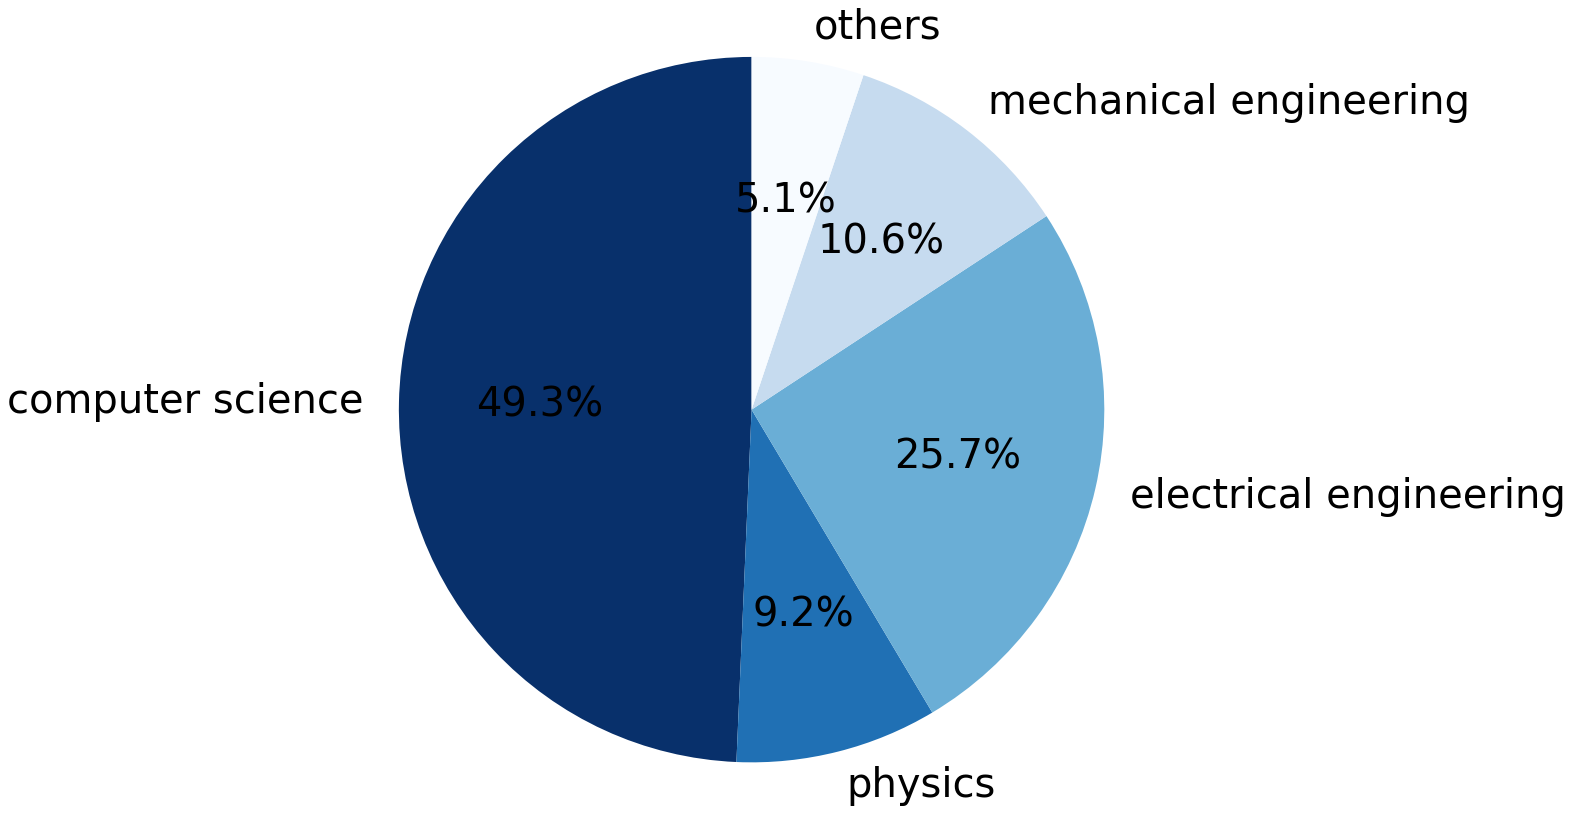

In [100]:
conn = sqlite3.connect('indeed.db')
c = conn.cursor()
#select in jobs all unique values in column = employer
sql_manager = "SELECT jobkey, qualifications_req FROM qualifications;"
c.execute(sql_manager)
result = c.fetchall()
nb_entry = len(result)
qualifs = {}

for this_job in result:
    this_jobkey = this_job[0]
    qualif = this_job[1]
    #make sure the extracted cell is not empty
    if qualif in ['computer science', 'cs']:
        qualif = 'computer science'
        if qualif in qualifs:
            qualifs['computer science'] += 1
        else:
            qualifs['computer science'] = 1
    
    elif qualif in ['mechanical engineering', 'me']:
        qualif = 'mechanical engineering'
        if qualif in qualifs:
            qualifs['mechanical engineering'] += 1
        else:
            qualifs['mechanical engineering'] = 1
            
    elif qualif == 'physics':
        if qualif in qualifs:
            qualifs['physics'] += 1
        else:
            qualifs['physics'] = 1
            
    elif qualif in ['industrial engineering', 'ie']:
        qualif ='industrial engineering'
        if qualif in qualifs:
            qualifs[qualif] += 1
        else:
            qualifs[qualif] = 1           
                    
    elif qualif in ['electrical engineering', 'ee']:
        qualif = 'electrical engineering'
        if qualif in qualifs:
            qualifs[qualif] += 1
        else:
            qualifs[qualif] = 1    
            
    elif qualif in ['computer engineering', 'ce']:
        qualif = 'computer engineering'
        if qualif in qualifs:
            qualifs[qualif] += 1
        else:
            qualifs[qualif] = 1  

print('Total Nbr of degrees {}'.format(len(qualifs)) )
print(qualifs)
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
sum_sz = 0

for this_qualif in qualifs:
    pct = qualifs[this_qualif]*1.0/nb_entry
    if pct > 0.05:
        sizes.append(pct)
        sum_sz = sum_sz + pct
        labels.append(this_qualif)

others_sz = 1 - sum_sz
sizes.append(others_sz)
labels.append('others')
#explode = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
mpl.rcParams['font.size'] = 40
fig1, ax1 = plt.subplots(figsize=(14,14))
cmap = plt.cm.Blues
colors = cmap(np.linspace(1, 0, 5))
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()